In [1]:
from aemeasure import read_as_pd
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()


In [2]:
from pcpptc import PolygonInstance, Solution
from pcpptc.plot import setup_plot, plot_polygon_instance, plot_solution
from pcpptc.plot.polgyon_instance import plot_coverage

In [3]:
read_as_pd("./solutions2/2.results.json").columns

Loaded dataframe ./solutions2/2.results.json
Executed on: ['algry03' 'algry01']
During: 2021-08-20 16:20:25.305058 and 2021-08-23 19:12:10.324509


Index(['solution', 'coverage', 'touring_cost', 'length', 'turn_sum',
       'instance', 'instance_path', 'runtime', 'timestamp', 'hostname', 'argv',
       'git_revision', 'cwd', 'solver', 'i', 'turn_factor'],
      dtype='object')

In [4]:
tables = []
for f in os.listdir("./solutions2"):
    if not f.endswith(".results.json"):
        continue
    f = os.path.join("./solutions2", f)
    tables.append(read_as_pd(f))

data = pd.concat(tables, ignore_index=True)
data.groupby(["solver"])["instance"].nunique()

Loaded dataframe ./solutions2/75.results.json
Executed on: ['algry01']
During: 2021-08-23 21:15:25.537704 and 2021-08-23 21:18:47.477030
Loaded dataframe ./solutions2/156.results.json
Executed on: ['algry01']
During: 2021-08-23 17:28:07.922508 and 2021-08-23 17:29:58.018417
Loaded dataframe ./solutions2/119.results.json
Executed on: ['algry01']
During: 2021-08-23 21:52:15.380986 and 2021-08-23 22:01:16.874869
Loaded dataframe ./solutions2/173.results.json
Executed on: ['algry01']
During: 2021-08-23 21:37:08.068632 and 2021-08-23 21:42:46.264003
Loaded dataframe ./solutions2/144.results.json
Executed on: ['algry03' 'algry01']
During: 2021-08-20 16:24:14.480837 and 2021-08-23 19:20:55.900008
Loaded dataframe ./solutions2/185.results.json
Executed on: ['algry01']
During: 2021-08-23 22:28:15.147155 and 2021-08-23 22:31:34.907581
Loaded dataframe ./solutions2/154.results.json
Executed on: ['algry01']
During: 2021-08-23 20:02:03.554251 and 2021-08-23 20:07:16.064666
Loaded dataframe ./soluti

solver
MeshAlgorithm(0.95)                                                                                                   64
MeshAlgorithm(0.95, full_coverage=False)                                                                             199
MeshAlgorithm(0.95, full_coverage=True)                                                                              199
RotatingHexagonalAlgorithm(RotatingRegularHexagonal(full_coverage=False, point_based=False, with_boundary=False))    199
RotatingHexagonalAlgorithm(RotatingRegularHexagonal(full_coverage=True, point_based=False, with_boundary=False))     199
Name: instance, dtype: int64

In [6]:
data.dropna(inplace=True)
data = data[data["solver"] != "MeshAlgorithm(0.95)"]
data.groupby(["solver"])["instance"].nunique()

solver
MeshAlgorithm(0.95, full_coverage=False)                                                                             199
MeshAlgorithm(0.95, full_coverage=True)                                                                              199
RotatingHexagonalAlgorithm(RotatingRegularHexagonal(full_coverage=False, point_based=False, with_boundary=False))    199
RotatingHexagonalAlgorithm(RotatingRegularHexagonal(full_coverage=True, point_based=False, with_boundary=False))     199
Name: instance, dtype: int64

In [7]:
from pcpptc.instance_converter.dmsh import GmshGrid


def rename(s):
    names = {
        "RotatingHexagonalAlgorithm(RotatingRegularHexagonal(full_coverage=False, point_based=False, with_boundary=False))": "Regular (Partial)",
        "RotatingHexagonalAlgorithm(RotatingRegularHexagonal(full_coverage=True, point_based=False, with_boundary=False))": "Regular (Full)",
        "RotatingHexagonalAlgorithm(RotatingRegularHexagonal(full_coverage=True, point_based=True, with_boundary=False))": "Regular (Full, PB)",
        "MeshAlgorithm(0.95, full_coverage=False)": "Mesh (Partial)",
        "MeshAlgorithm(0.95, full_coverage=True)": "Mesh (Full)",
    }
    return names.get(s, s)


data["solver"] = data["solver"].apply(rename)
data = data[data["solver"] != "Regular (Full, PB)"]

In [8]:
data = data[data["solver"] == "Mesh (Partial)"]

In [27]:
t = data.sample(35).reindex()
instances = [
    PolygonInstance.from_json(file_path=instance)
    for instance in t["instance_path"].unique()
]
max_value = 0.5 * max(
    max((v[1] for v in instance.valuable_areas), default=0.0) for instance in instances
)
max_expense = max(
    max((v[1] for v in instance.expensive_areas), default=0.0) for instance in instances
)

In [28]:
def plot(row, path=None, ax=None):
    instance_path = row["instance_path"]
    instance = PolygonInstance.from_json(file_path=instance_path)
    solution = Solution.from_json(data=row["solution"])
    if not ax:
        ax = setup_plot(figsize=(4.5, 4.5))
    plot_polygon_instance(
        ax,
        instance,
        set_limits=True,
        relative_value=max_value,
        relative_expense=max_expense,
    )
    plot_solution(ax, solution, color="blue")
    # plot_coverage(ax, instance, solution)
    # plt.title(f"Solver: {row['solver']}, Cost: {round(row['touring_cost'],2)}, Coverage: {round(100*row['relative_coverage'],1)}%")
    if path:
        plt.tight_layout()
        plt.savefig(path)

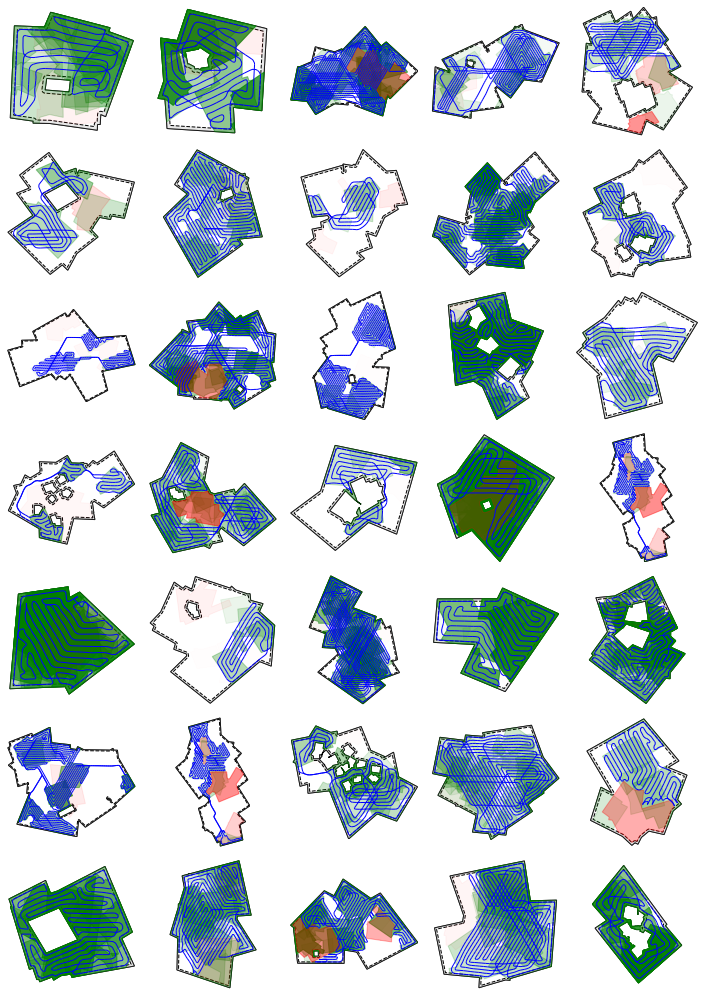

In [34]:
fig, axes = plt.subplots(7, 5, figsize=(10, 14))
plt.tight_layout()
for i in range(0, 35):
    # ax = axes[i//5, i%5]
    ax = axes[i // 5, i % 5]
    ax.set_aspect("equal", adjustable="box")
    # plot_polygon_instance(ax, instances[i],set_limits=False)
    plot(t.iloc[i], ax=ax)
    ax.axis("off")
plt.autoscale()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=-0.2, hspace=-0.2)
plt.tight_layout()
plt.savefig("05_examples.pdf")
plt.show()